loss is [5.1518906e+01 4.6968058e-02 5.1565872e+01]
loss is [0.00806131 0.00260593 0.01066724]
loss is [2.1699723e-03 8.5838547e-06 2.1785561e-03]
loss is [1.1327087e-03 3.2565049e-06 1.1359652e-03]
loss is [7.7225186e-04 1.0927454e-06 7.7334460e-04]
loss is [6.3467200e-04 4.2582218e-07 6.3509785e-04]
loss is [5.5553392e-04 2.1242421e-07 5.5574632e-04]
loss is [4.9018813e-04 1.3561679e-07 4.9032376e-04]
loss is [4.3000601e-04 1.0259725e-07 4.3010860e-04]
loss is [3.7431641e-04 8.4212097e-08 3.7440064e-04]


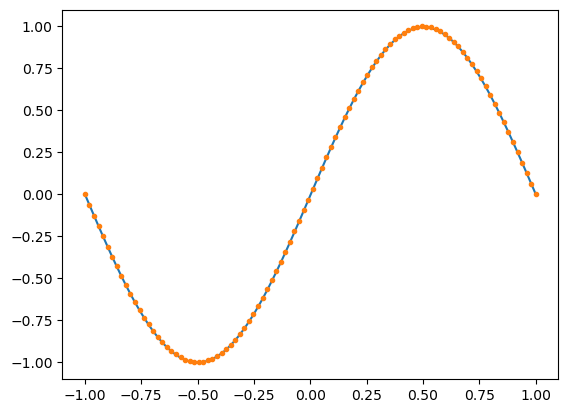

In [4]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib

from user_funn.field import D1Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad

# 保证迭代参数与DEEPXDE一致
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

## define a pde
pde_epoch_size = 16
pde_batch_num = 1
pde_batch_size = pde_epoch_size//pde_batch_num
pde_input = D1Field([-1,1]).get_field_rand(pde_epoch_size)
pde_output = np.zeros([pde_epoch_size,1])

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)
    u = U[:,[0]]
    dudx = grad(u, x_in)[0]
    du2dx2 = grad(dudx, x_in)[0]
    loss = -du2dx2 - (torch.pi ** 2) * torch.sin(torch.pi * x_in)
    loss = loss_fn(loss, y_real)
    return loss

## define a bc
bc_epoch_size = 2
bc_batch_num = 1
bc_batch_size = bc_epoch_size//bc_batch_num
bc_input = np.array([[-1],[1]])
bc_output = np.zeros([bc_epoch_size ,1])
bc_batch_size = bc_epoch_size

from user_funn.bc import data_loss_factory
data_loss = data_loss_factory(loss_fn,[0])

solver = CloudPointSolver(
    [[pde_input, pde_output],[bc_input, bc_output]],
    [pde_loss,data_loss],
    model = [1, 100, 100, 100, 1],
    optimizer = "adam",
    batchsize = [pde_batch_size,bc_batch_size])

epoch_num = 1000
for i in range(epoch_num):
    solver.train_step()
    if i%100 == 0:
        solver.test_step(print_flag=True)

x_cpu = np.linspace(-1,1,100).reshape(100,1)
y_cpu = solver.model_eval(x_cpu)

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(x_cpu,y_cpu)
ax.plot(x_cpu,np.sin(np.pi*x_cpu),'.')